# Problem set 7

## Name: Baite Pang

## Link to your PS7 github repo:

### Problem 0 

-2 points for every missing green OK sign. 

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.10"):
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "2.2.5", 'matplotlib': "3.10.1",'sklearn': "1.6.1", 
                'pandas': "2.2.3",'xgboost': "3.0.0", 'shap': "0.47.2", 
                'polars': "1.27.1", 'seaborn': "0.13.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.10

[ OK ] numpy version 2.2.5 is installed.
[ OK ] matplotlib version 3.10.1 is installed.
[ OK ] sklearn version 1.6.1 is installed.
[ OK ] pandas version 2.2.3 is installed.
[ OK ] xgboost version 3.0.0 is installed.
[ OK ] shap version 0.47.2 is installed.
[ OK ] polars version 1.27.1 is installed.
[ OK ] seaborn version 0.13.2 is installed.


### Problem 1a (10 points)

Please load the true_labels_pred_probs.csv file from the data folder into a data frame. It contains the true labels and the predicted probabilities of class 0 and 1 in a classification problem. Class 0 indicates a patient does not have a disease, while Class 1 indicates that a patient does have the disease.

Please prepare the predicted classes for a critical probability of 25%, 50%, and 75% and create three confusion matrix plots. Put the critical probability value in the title of each graph. In a paragraph, explain how the model's performance is impacted by the critical probability with respect to the confusion matrices. Given the model's specified deployment task, what are the implications of choosing one of the critical probabilities over the other?

In [17]:
# your code here
import pandas as pd 
import numpy as np
import os
from pathlib import Path
path = Path.home() / "Documents" / "data1030-fall2025" / "data" / "true_labels_pred_probs.csv"
df = pd.read_csv(path)
df.head()

,y_true,pred_prob_class0,pred_prob_class1
0,0,0.705171,0.294829
1,0,0.811506,0.188494
2,1,0.123507,0.876493
3,0,0.932019,0.067981
4,0,0.884029,0.115971


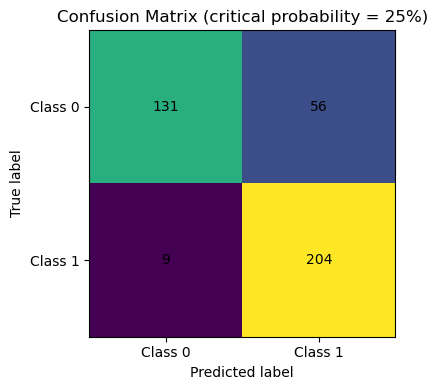

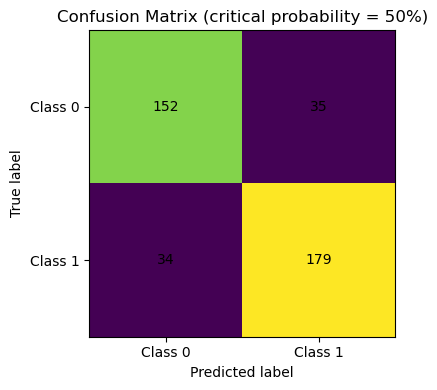

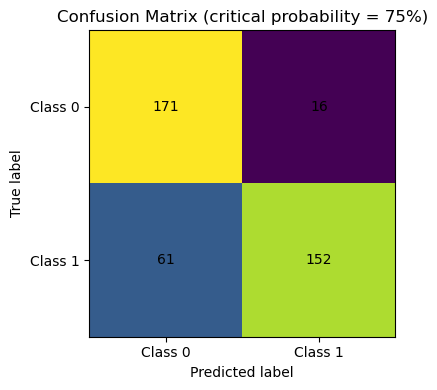

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_col = "y_true"
p1_col = None

if "pred_prob_class1" in df.columns:
    p1_col = "pred_prob_class1"
elif "pred_prob_class0" in df.columns:
    df["pred_prob_class1"] = 1.0 - df["pred_prob_class0"].astype(float)
    p1_col = "pred_prob_class1"
else:
    raise ValueError("Expected a 'pred_prob_class1' or 'pred_prob_class0' column in df.")

y_true = df[y_col].astype(int).to_numpy()
prob1  = df[p1_col].astype(float).to_numpy()

def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(4.2, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Class 0", "Class 1"])
    ax.set_yticklabels(["Class 0", "Class 1"])

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, str(val), ha="center", va="center")

    plt.tight_layout()
    plt.show()

thresholds = [0.25, 0.50, 0.75]
for t in thresholds:
    y_pred = (prob1 >= t).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # [[TN, FP],[FN, TP]]
    plot_cm(cm, title=f"Confusion Matrix (critical probability = {int(t*100)}%)")


**your explanation here**

That increases recall/sensitivity (fewer false negatives) but also increases false positives (lower specificity). Raising the threshold does the opposite: you’ll get higher specificity (fewer false positives) but lower sensitivity (more missed true cases). For deployment: if this is an early screening tool where missing a sick patient is costly, a lower threshold (e.g., 25%) is safer and can be followed by confirmatory tests. If it’s a confirmatory model where unnecessary follow-ups are costly and missing a case is less risky, a higher threshold (e.g., 75%) may be preferable.

### Problem 1b (9 points)

Calculate and plot the accuracy, precision, recall, f0.5, f1, and f1.5 scores using the sorted values of the Class 1 predicted probabilities.

What critical probability maximizes each of the scores (one critical probability per score)? That critical probability is what you should use to maximize the scores.

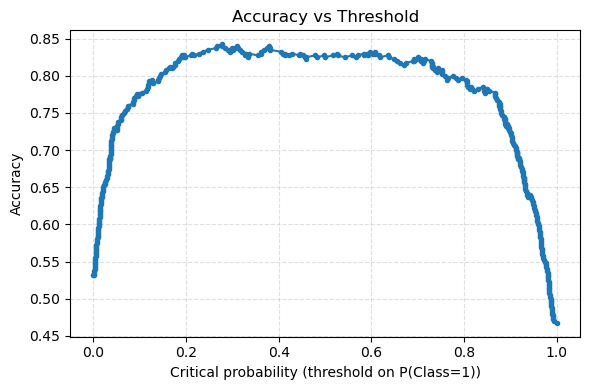

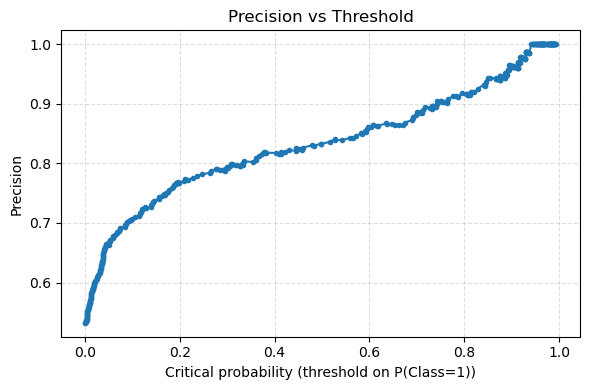

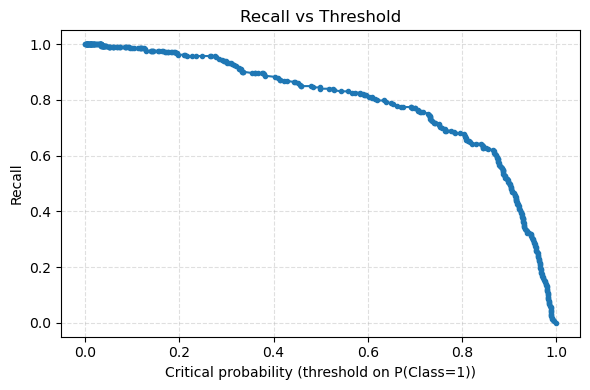

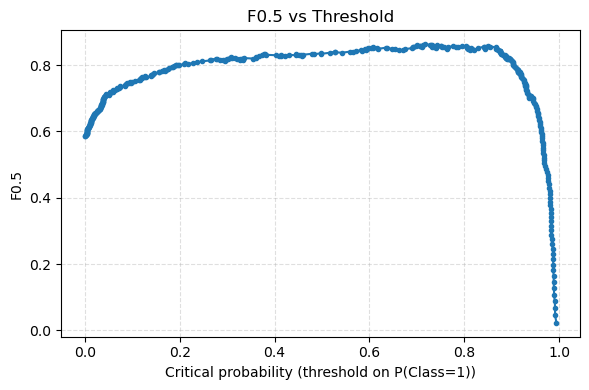

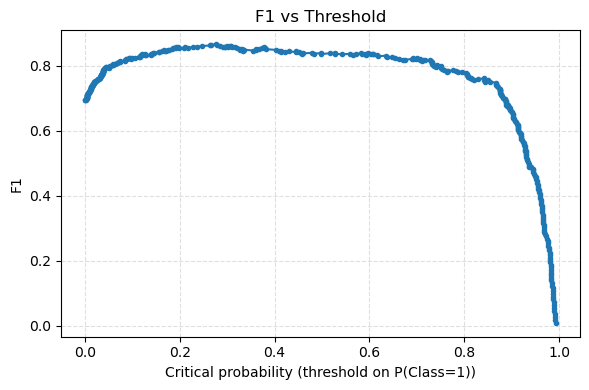

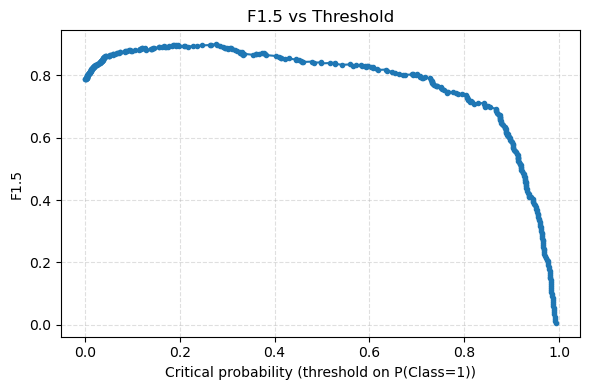


Best critical probability per metric:
  accuracy : threshold = 0.2768, score = 0.8425
  precision: threshold = 0.9417, score = 1.0000
  recall   : threshold = 0.0000, score = 1.0000
  f0.5     : threshold = 0.7165, score = 0.8628
  f1       : threshold = 0.2768, score = 0.8662
  f1.5     : threshold = 0.2768, score = 0.8993


In [23]:
import numpy as np
import matplotlib.pyplot as plt

thr = np.unique(prob1)
thr = np.r_[0.0, thr, 1.0] 


def safe_div(a, b):
    return a / b if b != 0 else np.nan

def fbeta(prec, rec, beta):
    if np.isnan(prec) or np.isnan(rec) or (prec == 0 and rec == 0):
        return np.nan
    b2 = beta**2
    denom = b2*prec + rec
    return (1 + b2) * prec * rec / denom if denom != 0 else np.nan


N = len(y_true)
accs, precs, recs, f05s, f1s, f15s = [], [], [], [], [], []

for t in thr:
    y_pred = (prob1 >= t).astype(int)

    TP = int(((y_true == 1) & (y_pred == 1)).sum())
    FP = int(((y_true == 0) & (y_pred == 1)).sum())
    TN = int(((y_true == 0) & (y_pred == 0)).sum())
    FN = int(((y_true == 1) & (y_pred == 0)).sum())

    acc = (TP + TN) / N
    prec = safe_div(TP, TP + FP)
    rec  = safe_div(TP, TP + FN)

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f05s.append(fbeta(prec, rec, 0.5))
    f1s.append(fbeta(prec, rec, 1.0))
    f15s.append(fbeta(prec, rec, 1.5))

accs  = np.array(accs)
precs = np.array(precs)
recs  = np.array(recs)
f05s  = np.array(f05s)
f1s   = np.array(f1s)
f15s  = np.array(f15s)


def plot_metric(x, y, title, ylabel):
    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker='.')
    plt.title(title)
    plt.xlabel("Critical probability (threshold on P(Class=1))")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_metric(thr, accs,  "Accuracy vs Threshold", "Accuracy")
plot_metric(thr, precs, "Precision vs Threshold", "Precision")
plot_metric(thr, recs,  "Recall vs Threshold", "Recall")
plot_metric(thr, f05s,  "F0.5 vs Threshold", "F0.5")
plot_metric(thr, f1s,   "F1 vs Threshold", "F1")
plot_metric(thr, f15s,  "F1.5 vs Threshold", "F1.5")

def best_at(y):
    if np.all(np.isnan(y)):
        return np.nan, np.nan
    idx = np.nanargmax(y)
    return thr[idx], y[idx]

best = {
    "accuracy": best_at(accs),
    "precision": best_at(precs),
    "recall": best_at(recs),
    "f0.5": best_at(f05s),
    "f1": best_at(f1s),
    "f1.5": best_at(f15s),
}

print("\nBest critical probability per metric:")
for name, (t, val) in best.items():
    print(f"  {name:9s}: threshold = {t:.4f}, score = {val:.4f}")


### Problem 1c (3 points)

One of the curves you plotted is non-decreasing and another curve is non-increasing. Which evaluation metrics correspond to these two curves and why is this a problem when you try to tune the critical probability? Explain your answer in a few sentences.


**your explanation here**

Non-decreasing curve: Precision vs threshold. As you raise the critical probability, you label fewer cases as positive, so FP never increases and you usually keep only the highest-score positives—precision (TP/(TP+FP)) tends to go up (or stay flat).
Non-increasing curve: Recall vs threshold. Raising the threshold can only keep or drop positives, never add new ones, so TP can only go down (or stay), making recall (TP/(TP+FN)) go down (or stay).

Plus, a monotonic metric has its optimum at an extreme threshold (recall maximized at a very low threshold to predict almost everyone positive; precision maximized at a very high threshold to predict almost no one positive). Those are degenerate classifiers. That’s why we don’t tune threshold by pure precision or pure recall; we use balanced metrics (Fβ, F1) or a cost/utility function that trades off FP vs. FN.


### Problem 2a (5 points)

Work with true_labels_pred_probs.csv again. 

Calculate the points on the ROC curve and plot it. 

Print out the best critical probability by finding the point on the ROC curve that's closest to the perfect classifier (0,1) point. 

Check out the wikipedia page of the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Further_interpretations) to read more about other ways to determine the best critical probability, and other ways to summarize the ROC curve.

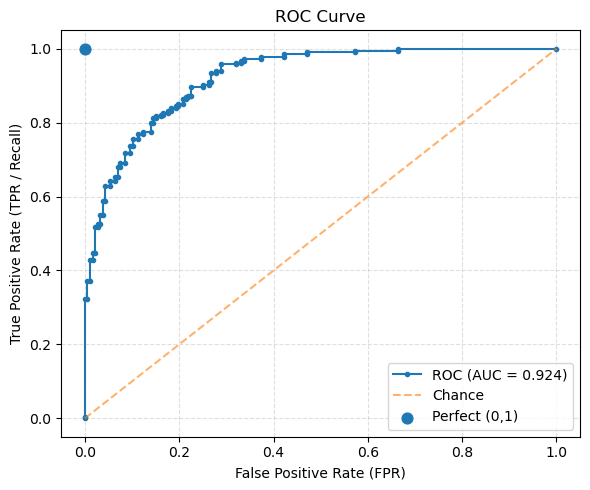

Best threshold by min distance to (0,1):
  threshold = 0.596730
  FPR = 0.149733, TPR = 0.816901, AUC = 0.923652


In [ ]:
# your code here 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_thr = roc_curve(y_true, prob1)   
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, marker='.', label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle='--', alpha=0.6, label="Chance")
plt.scatter(0,1, s=60, zorder=5, label="Perfect (0,1)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


d2 = (fpr - 0.0)**2 + (tpr - 1.0)**2
best_idx = int(np.argmin(d2))
best_thr = roc_thr[best_idx]

if np.isinf(best_thr):
    best_thr_print = 1.0
else:
    best_thr_print = float(best_thr)

print("Best threshold by min distance to (0,1):")
print(f"  threshold = {best_thr_print:.6f}")
print(f"  FPR = {fpr[best_idx]:.6f}, TPR = {tpr[best_idx]:.6f}, AUC = {roc_auc:.6f}")


### Problem 2b (10 points)

We discussed in class that the baseline accuracy of a classification model is equal to the fraction of points that belong to the most populous class. For example, if 80% of points belong to class 0 and 20% of points belong to class 1, we could predict class 0 for all points and the accuracy of our model would be 80%. In general, the baseline score is the best score you can achieve knowing no additional information about the features. You use information about your target variable only (in this case, only what percent of points are in each class). Keep this concept and methodology in mind and answer the questions below.

Q1: How do you calculate the baseline f1 score in classification? Let's assume $n_0$ points are in class 0 and $n_1 = n - n_0$ points are in class 1 where $n$ is the number of points in your dataset, and $n_0 > n_1$ so class 1 is the minority class. Work out the solution on pen and paper. Express the f1 score using $p$ (precision) and/or $r$ (recall).

**your explanation here**

- n = total samples
- n0 = # in class 0 (majority), n1 = # in class 1 (minority) = n − n0, with n0 > n1
- π0 = n0 / n (majority proportion), π1 = n1 / n = 1 − π0
- **Baseline classifier**: always predict class 0

**Confusion (under this baseline)**
- For class 0 as “positive”: TP0 = n0, FP0 = n1, FN0 = 0
- For class 1 as “positive”: TP1 = 0, FP1 = 0, FN1 = n1

**Per-class precision/recall/F1**
- Class 0:
  - p0 = TP0 / (TP0 + FP0) = n0 / n = π0
  - r0 = TP0 / (TP0 + FN0) = 1
  - F1_0 = 2 * p0 * r0 / (p0 + r0) = 2 * π0 / (1 + π0)  (same as 2n0 / (2n0 + n1))
- Class 1:
  - p1 = 0 (we never predict class 1)
  - r1 = 0
  - F1_1 = 0


- If “F1” = F1 of the minority class (common when class 1 is the positive class):
  - **Baseline F1 = 0**
- If using multiclass-style aggregates:
  - **Macro-F1** = (F1_0 + F1_1)/2 = [2π0/(1+π0)] / 2 = **π0 / (1 + π0)**
  - **Weighted-F1** = π0 * F1_0 + π1 * F1_1 = π0 * [2π0/(1+π0)] = **2π0² / (1 + π0)**
  - **Micro-F1** (equals accuracy in single-label) = **π0** = n0 / n


Q2: Generalize your Q1 solution to the f_beta score. Usually the f_beta score is used when the classification problem is imbalanced. Prepare a figure which shows the baseline f_beta score for beta = 0.5, 1, and 2 when the fraction of points that belong to class 0 is between 0.95 and 1 in the target variable. Use 51 linearly spaced values between 0.95 and 1.
Create a plot with three curves, one curve per beta value. Don't forget to add axes labels, a title, and a legend.

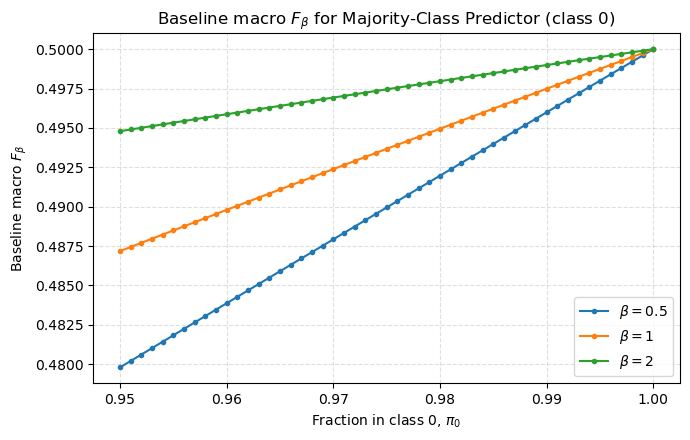

In [34]:
import matplotlib.pyplot as plt

pi0 = np.linspace(0.95, 1.0, 51)
def macro_fbeta_baseline(pi0, beta):
    return ((1 + beta**2) / 2.0) * (pi0) / (beta**2 * pi0 + 1.0)

betas = [0.5, 1.0, 2.0]
labels = [r"$\beta=0.5$", r"$\beta=1$", r"$\beta=2$"]

plt.figure(figsize=(7,4.5))
for b, lab in zip(betas, labels):
    y = macro_fbeta_baseline(pi0, b)
    plt.plot(pi0, y, marker='.', label=lab)

plt.xlabel(r"Fraction in class 0, $\pi_0$")
plt.ylabel("Baseline macro $F_\\beta$")
plt.title("Baseline macro $F_\\beta$ for Majority-Class Predictor (class 0)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Problem 2c (10 points)

So far, we've discussed calculating f1 scores in binary classification problems. However, for multiclass problems, there are multiple ways to calculate an f1 score. Look up three different approaches and explain how to calculate them in a short description with equations. Create a simple toy dataset and calculate the f1 scores using sklearn. Discuss the pros and cons of each approach.

In [ ]:
from sklearn.metrics import f1_score, classification_report

rng = np.random.default_rng(7)
y_true = np.array([0]*60 + [1]*30 + [2]*10)

y_pred = []


for _ in range(60):
    r = rng.random()
    if r < 0.90: y_pred.append(0)
    elif r < 0.95: y_pred.append(1)
    else: y_pred.append(2)


for _ in range(30):
    r = rng.random()
    if r < 0.70: y_pred.append(1)
    elif r < 0.90: y_pred.append(0)
    else: y_pred.append(2)


for _ in range(10):
    r = rng.random()
    if r < 0.40: y_pred.append(2)
    elif r < 0.85: y_pred.append(1)
    else: y_pred.append(0)

y_pred = np.array(y_pred)

# Compute F1s
per_class = f1_score(y_true, y_pred, average=None)       
macro     = f1_score(y_true, y_pred, average="macro")     
weighted  = f1_score(y_true, y_pred, average="weighted")  
micro     = f1_score(y_true, y_pred, average="micro")    

print("Per-class F1: [class0, class1, class2] =", np.round(per_class, 4).tolist())
print(f"Macro-F1   : {macro:.4f}")
print(f"Weighted-F1: {weighted:.4f}")
print(f"Micro-F1   : {micro:.4f}  (== accuracy in single-label multiclass)")

print("\nClassification report (precision/recall/F1 by class):\n")
print(classification_report(y_true, y_pred, digits=4))


Per-class F1: [class0, class1, class2] = [0.9333, 0.807, 0.5217]
Macro-F1   : 0.7540
Weighted-F1: 0.8543
Micro-F1   : 0.8500  (== accuracy in single-label multiclass)

Classification report (precision/recall/F1 by class):

              precision    recall  f1-score   support

           0     0.9333    0.9333    0.9333        60
           1     0.8519    0.7667    0.8070        30
           2     0.4615    0.6000    0.5217        10

    accuracy                         0.8500       100
   macro avg     0.7489    0.7667    0.7540       100
weighted avg     0.8617    0.8500    0.8543       100



**your explanation here**

1. Macro-averaged F1:
For class k:
  Precision_k = TP_k / (TP_k + FP_k)
  Recall_k    = TP_k / (TP_k + FN_k)
  F1_k        = 2 * Precision_k * Recall_k / (Precision_k + Recall_k)
              = 2 * TP_k / (2*TP_k + FP_k + FN_k)

Macro-F1 = (1 / K) * sum_{k=1..K} F1_k
Pros: Sensitive to minority-class performance; each class counts the same.
Cons: Can look “harsh” on imbalanced data if rare classes are tough.

2. Weighted-averaged F1
Let n_k = number of true examples in class k, and N = sum_k n_k.

Weighted-F1 = sum_{k=1..K} (n_k / N) * F1_k
Pros: Reflects the dataset’s class mix; often tracks overall utility on imbalanced data.
Cons: Strong classes (large 𝑛k) can hide poor minority-class performance.

3. Micro-averaged F1
TP_micro = sum_k TP_k
FP_micro = sum_k FP_k
FN_micro = sum_k FN_k

Precision_micro = TP_micro / (TP_micro + FP_micro)
Recall_micro    = TP_micro / (TP_micro + FN_micro)

Micro-F1 = 2 * Precision_micro * Recall_micro
           / (Precision_micro + Recall_micro)
Pros: Measures overall instance-level correctness; common in multi-label too.
Cons: Dominated by majority classes; can obscure rare-class performance.

### Problem 3 (5 points)

The true and predicted target variables of a regression problem are available in the `data/reg.cvs`. The goal of the model is to predict people's ages so the target variable's unit is year. 

We discussed the R2 score in class:

$R^2(y,y') = 1 - \frac{\sum_{i=1}^{n}(y_i-y_i')^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$,
where $\bar{y}$ is the mean of $y$.

The baseline (or constant) regression model returns the mean of $y$ as prediction for all data points ($y_i' == \bar{y}$ for all $i$). So the baseline R2 score is 0.

Calculate and print the baseline R2, MSE, RMSE, and MAE, **assuming that $y_i' == \bar{y}$ for all $i$**. Make sure to include the units for each metric. 

Next, calculate and print the R2 score, MSE, RMSE, and MAE **using the model predictions** and add the units of the metrics.

In [35]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

path = Path.home() / "Documents" / "data1030-fall2025" / "data" / "reg.csv"
df = pd.read_csv(path)
df.head()

,y_true,y_pred
0,48.712290,49.582760
1,95.958573,92.968500
2,78.023503,78.941111
3,67.089996,47.214307
4,30.793529,28.596810


In [36]:
# your code here

true_candidates   = ["y", "y_true", "target", "age_true", "age"]
pred_candidates   = ["y_pred", "yhat", "y_hat", "pred", "prediction", "age_pred"]

def pick(colnames):
    for c in colnames:
        if c in df.columns:
            return c
    raise ValueError(f"Could not find any of {colnames} in columns: {list(df.columns)}")

y_col     = pick(true_candidates)
yp_col    = pick(pred_candidates)

y   = df[y_col].to_numpy(dtype=float)
yp  = df[yp_col].to_numpy(dtype=float)


ybar = float(np.mean(y))
yp_base = np.full_like(y, ybar, dtype=float)


mse_base  = mean_squared_error(y, yp_base)                
rmse_base = float(np.sqrt(mse_base))                       
mae_base  = mean_absolute_error(y, yp_base)                
r2_base   = r2_score(y, yp_base)                           


mse_model  = mean_squared_error(y, yp)                     
rmse_model = float(np.sqrt(mse_model))                     
mae_model  = mean_absolute_error(y, yp)                    
r2_model   = r2_score(y, yp)                              


print("=== Baseline (constant = mean(y)) ===")
print(f"R2      : {r2_base:,.4f}  (unitless; baseline R2 should be 0)")
print(f"MSE     : {mse_base:,.4f}  years^2")
print(f"RMSE    : {rmse_base:,.4f}  years")
print(f"MAE     : {mae_base:,.4f}  years")

print("\n=== Model (given predictions) ===")
print(f"R2      : {r2_model:,.4f}  (unitless)")
print(f"MSE     : {mse_model:,.4f}  years^2")
print(f"RMSE    : {rmse_model:,.4f}  years")
print(f"MAE     : {mae_model:,.4f}  years")



=== Baseline (constant = mean(y)) ===
R2      : 0.0000  (unitless; baseline R2 should be 0)
MSE     : 589.1229  years^2
RMSE    : 24.2719  years
MAE     : 21.3478  years

=== Model (given predictions) ===
R2      : 0.8599  (unitless)
MSE     : 82.5107  years^2
RMSE    : 9.0835  years
MAE     : 7.2112  years
